# 🔍 Abnormality Detection in Musculo-Skeletal Radiographies

This notebook builds an end-to-end binary image classifier using TensorFlow 2.0.

## 1. Problem

Detecting the presence and diagnosing abnormalities and bone fractures in musculo-skeletal X-Rays. 

This would save time for medical specialists and increase the accuracy of diagnostics.

## 2. Data

The data we're using was found in the **MURA (MUsculoskeletal RAdiographs)**  dataset provided by the Stanford Machine Learning group, which was part of a competition to improve the performance of the baseline model that the authors used. This data is openly available at: https://stanfordmlgroup.github.io/competitions/mura/

## 3. Evaluation

The model is evaluated on Cohen’s kappa statistic.

## 4. Features

Information about the data:
* Our inputs are images (unstructured data)
* The images can be either positive (there is a bone fracture) or negative (there isn't a bone fracture)
* 14.863 studies were made
* The studies were made on 12.173 patients
* There are a total of 40.561 multi-view radiographic images of the patients
* Each study belongs to one of these body parts: elbow, finger, forearm, hand, humerus, shoulder, and wrist
* The data is already separated in training and validation sets

## 5. Getting our workspace ready

In [1]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2
import pathlib
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from os import listdir
from os.path import isfile, join
from pathlib import Path

2022-09-16 00:34:22.057688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("TF version:", tf.__version__)


TF version: 2.10.0


In [3]:
# Run this cell if you want untruncated dataframe outputs
# pd.set_option('display.max_colwidth', None)


## 6. EDA (Exploratory Data Analysis)

In [4]:
# Check out the labels of our training data
train_labels_df = pd.read_csv("/Users/felipesanmartin/Study/TFG/data/MURA-v1.1/train_labeled_studies.csv", 
                               names = ["file", "abnormal"])
print(train_labels_df.describe())
train_labels_df.head()

           abnormal
count  13457.000000
mean       0.384707
std        0.486544
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


,file,abnormal
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [5]:
# Quick look at the validation data
val_labels_df = pd.read_csv("/Users/felipesanmartin/Study/TFG/data/MURA-v1.1/valid_labeled_studies.csv",
                             names = ["file", "abnormal"])
print(val_labels_df.describe())
val_labels_df.head()

          abnormal
count  1199.000000
mean      0.448707
std       0.497570
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000


,file,abnormal
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


In [6]:
val_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   file      1199 non-null   object
 1   abnormal  1199 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.9+ KB


In [7]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13457 entries, 0 to 13456
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   file      13457 non-null  object
 1   abnormal  13457 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 210.4+ KB


We have no null labels in our data set.

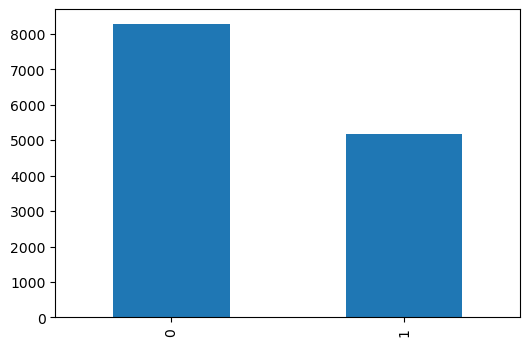

In [8]:
# How many abnormal cases do we have in our training set?
train_labels_df["abnormal"].value_counts().plot.bar(figsize = (6, 4));

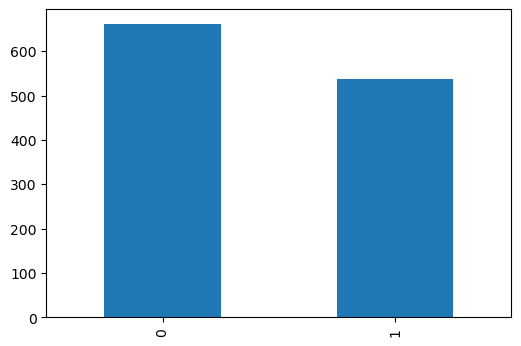

In [9]:
# In our validation set?
val_labels_df["abnormal"].value_counts().plot.bar(figsize = (6, 4));

In [10]:
train_images_path = pd.read_csv("/Users/felipesanmartin/Study/TFG/data/MURA-v1.1/train_image_paths.csv",
                           names = ["path"])
train_images_path.head()
train_images_path

,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...


In [11]:
val_images_path = pd.read_csv("/Users/felipesanmartin/Study/TFG/data/MURA-v1.1/valid_image_paths.csv",
                              names = ["path"])
val_images_path.head()

,path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


## 7. Data processing

In [12]:
# Add /Users/felipesanmartin/Study/TFG/data to all the paths in train_images_path
filenames = ["/Users/felipesanmartin/Study/TFG/data/" + fname for fname in train_images_path["path"]]
train_images_path["path"] = filenames
train_images_path.head()

# and the same for the validation data
filenames = ["/Users/felipesanmartin/Study/TFG/data/" + fname for fname in val_images_path["path"]]
val_images_path["path"] = filenames
val_images_path.head()


,path
0,/Users/felipesanmartin/Study/TFG/data/MURA-v1....
1,/Users/felipesanmartin/Study/TFG/data/MURA-v1....
2,/Users/felipesanmartin/Study/TFG/data/MURA-v1....
3,/Users/felipesanmartin/Study/TFG/data/MURA-v1....
4,/Users/felipesanmartin/Study/TFG/data/MURA-v1....


### Let's add a column that corresponds to the body part

In [13]:
val_images_path["path"][0]

'/Users/felipesanmartin/Study/TFG/data/MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png'

We can see that the body part is stated after the 7th `/` of the filepath. Let's get a list of all the body parts

In [14]:
train_path = "data/MURA-v1.1/train"
body_parts = [f for f in listdir(train_path) if not isfile(join(train_path, f))]  # the isfile function is used to skip the files and only focus on folders  
body_parts

['XR_HAND',
 'XR_HUMERUS',
 'XR_FINGER',
 'XR_ELBOW',
 'XR_SHOULDER',
 'XR_WRIST',
 'XR_FOREARM']

In [15]:
train_images_path["path"][0]

'/Users/felipesanmartin/Study/TFG/data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png'

In [16]:
# Let's write a function to get the body part from the file name
def get_bodypart(path):
    bodypart = path.split(sep = "/")[8]
    return bodypart
    

In [17]:
mypath = "/Users/felipesanmartin/Study/TFG/data/MURA-v1.1/valid/XR_FINGER/patient11291/study1_positive/image1.png"
get_bodypart(mypath)

'XR_FINGER'

Now let's do this for all the files in the `train_images_path` and `val_images_path` dataframes

In [18]:
train_images_path["bodypart"] = [get_bodypart(i) for i in train_images_path["path"]]
val_images_path["bodypart"] = [get_bodypart(i) for i in val_images_path["path"]]
train_images_path

,path,bodypart
0,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER
1,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER
2,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER
3,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER
4,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER
...,...,...
36803,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_HAND
36804,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_HAND
36805,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_HAND
36806,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_HAND


In [19]:
val_images_path

,path,bodypart
0,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_WRIST
1,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_WRIST
2,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_WRIST
3,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_WRIST
4,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_WRIST
...,...,...
3192,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER
3193,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER
3194,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER
3195,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER


### Now let's add a column that indicates if there is an abnormality in the X-Ray images

The path of each image has a folder that indicates if it's positive or not. For example: `study1_positive`. We'll use this to create the column label.

In [20]:
mypath

'/Users/felipesanmartin/Study/TFG/data/MURA-v1.1/valid/XR_FINGER/patient11291/study1_positive/image1.png'

In [21]:
mypath.split(sep = "/")[10]

'study1_positive'

In [22]:
# Let's create a function that gives us the abnormality of the image from the name of the folder where it's contained
def get_abnormality(image_path):
    abnormality_folder = image_path.split(sep = "/")[10]
    if "positive" in abnormality_folder:
        return 1
    if "negative" in abnormality_folder:
        return 0  

In [23]:
train_images_path["abnormality"] = [get_abnormality(i) for i in train_images_path["path"]]
train_images_path.head()

,path,bodypart,abnormality
0,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
1,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
2,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
3,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
4,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1


In [24]:
val_images_path["abnormality"] = [get_abnormality(i) for i in val_images_path["path"]]
val_images_path.head()

,path,bodypart,abnormality
0,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_WRIST,1
1,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_WRIST,1
2,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_WRIST,1
3,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_WRIST,1
4,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_WRIST,1


### Now let's turn our bodypart column from string into numbers

In [25]:
# This will turn all of the sting values into categorical values
train_images_path["bodypart"] = train_images_path["bodypart"].astype("category").cat.as_ordered()
val_images_path["bodypart"] = val_images_path["bodypart"].astype("category").cat.as_ordered()

In [26]:
train_images_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36808 entries, 0 to 36807
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   path         36808 non-null  object  
 1   bodypart     36808 non-null  category
 2   abnormality  36808 non-null  int64   
dtypes: category(1), int64(1), object(1)
memory usage: 611.5+ KB


In [27]:
val_images_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   path         3197 non-null   object  
 1   bodypart     3197 non-null   category
 2   abnormality  3197 non-null   int64   
dtypes: category(1), int64(1), object(1)
memory usage: 53.5+ KB


In [28]:
train_images_path.bodypart.cat.categories

Index(['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS',
       'XR_SHOULDER', 'XR_WRIST'],
      dtype='object')

In [29]:
train_images_path.bodypart.cat.codes

0        5
1        5
2        5
3        5
4        5
        ..
36803    3
36804    3
36805    3
36806    3
36807    3
Length: 36808, dtype: int8

Now we can access the columns `bodypart` and `abnormality` in the form of numbers.

In [30]:
train_images_path.head()

,path,bodypart,abnormality
0,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
1,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
2,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
3,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
4,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1


### Merging the training and validation sets

Later we'll split the data into training, validation and test sets, so we'll have to merge the train and val dataframes to later split them again to get the test set.

In [31]:
# This cell merges the train_images_path and the val_images_path dataframes
mura_df = pd.concat([train_images_path, val_images_path])

In [32]:
mura_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40005 entries, 0 to 3196
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   path         40005 non-null  object  
 1   bodypart     40005 non-null  category
 2   abnormality  40005 non-null  int64   
dtypes: category(1), int64(1), object(1)
memory usage: 977.0+ KB


In [33]:
len(train_images_path) + len(val_images_path)

40005

In [34]:
mura_df.head()

,path,bodypart,abnormality
0,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
1,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
2,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
3,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
4,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1


In [35]:
mura_df.tail()

,path,bodypart,abnormality
3192,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
3193,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
3194,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
3195,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
3196,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0


In [36]:
mura_df

,path,bodypart,abnormality
0,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
1,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
2,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
3,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
4,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
...,...,...,...
3192,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
3193,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
3194,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
3195,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0


In [37]:
mura_df.loc[3196]

,path,bodypart,abnormality
3196,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
3196,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0


So the indexes weren't concatenated properly. Let's reset them.

In [38]:
mura_df = mura_df.reset_index()
mura_df = mura_df.drop(labels = "index", axis = 1)
mura_df

,path,bodypart,abnormality
0,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
1,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
2,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
3,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
4,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
...,...,...,...
40000,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
40001,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
40002,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
40003,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0


### Some more EDA

In [39]:
mura_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40005 entries, 0 to 40004
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   path         40005 non-null  object  
 1   bodypart     40005 non-null  category
 2   abnormality  40005 non-null  int64   
dtypes: category(1), int64(1), object(1)
memory usage: 664.6+ KB


In [40]:
mura_df.bodypart.value_counts()

XR_WRIST       10411
XR_SHOULDER     8942
XR_HAND         6003
XR_FINGER       5567
XR_ELBOW        5396
XR_FOREARM      2126
XR_HUMERUS      1560
Name: bodypart, dtype: int64

In [41]:
mura_crosstab = pd.crosstab(mura_df.bodypart,  mura_df.abnormality)
mura_crosstab

abnormality,0,1
bodypart,,
XR_ELBOW,3160,2236
XR_FINGER,3352,2215
XR_FOREARM,1314,812
XR_HAND,4330,1673
XR_HUMERUS,821,739
XR_SHOULDER,4496,4446
XR_WRIST,6129,4282


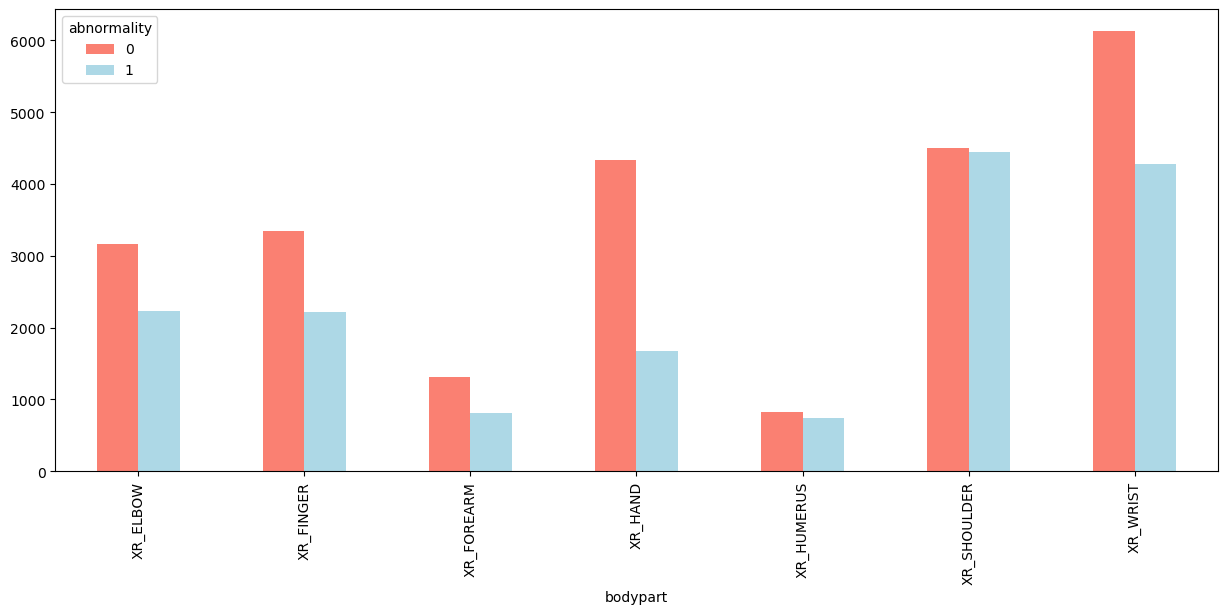

In [42]:
mura_crosstab.plot(kind = "bar",
                   figsize = (15,6),
                   color = ["salmon", "lightblue"]);

In [43]:
mura_crosstab["Fraction of abnormality"]= mura_crosstab[1]/(mura_crosstab[0]+mura_crosstab[1])
mura_crosstab

abnormality,0,1,Fraction of abnormality
bodypart,,,
XR_ELBOW,3160,2236,0.414381
XR_FINGER,3352,2215,0.397880
XR_FOREARM,1314,812,0.381938
XR_HAND,4330,1673,0.278694
XR_HUMERUS,821,739,0.473718
XR_SHOULDER,4496,4446,0.497204
XR_WRIST,6129,4282,0.411296


In [44]:
mura_df

,path,bodypart,abnormality
0,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
1,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
2,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
3,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
4,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
...,...,...,...
40000,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
40001,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
40002,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
40003,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0


### Visualizing some of the images

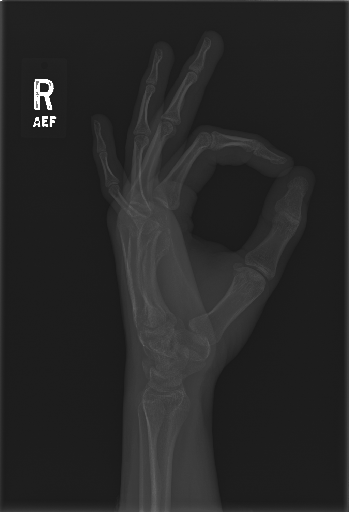

In [45]:
# Let's view an image
np.random.seed(76)
from IPython.display import Image
Image(mura_df.path.loc[np.random.randint(0,len(mura_df))])

In [46]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_16_images(image_paths, labels):
    
    """
    Displays a plot of 25 images and their labels.
    """
    
    # create figure
    fig = plt.figure(figsize=(20, 15))
    
    # setting values to rows and column variables
    rows = 4
    columns = 4
  
    # reading images
    random_index_list = np.random.randint(0, len(mura_df), size = rows*columns)
    example_images_path = [mura_df.path[random_index_list[i]] for i in range(rows*columns)]
    
    # Images to cv2 and transform again to RGB
    images_list = [cv2.imread(path) for path in example_images_path]
    for i in range(len(images_list)):
        images_list[i] = cv2.cvtColor(images_list[i], cv2.COLOR_BGR2RGB)
        
    # Plot loop
    for count, image in enumerate(images_list, start = 1):
        fig.add_subplot(rows, columns,count)
        plt.imshow(image);
        plt.axis("off")
        plt.title(mura_df["abnormality"][random_index_list[count-1]])

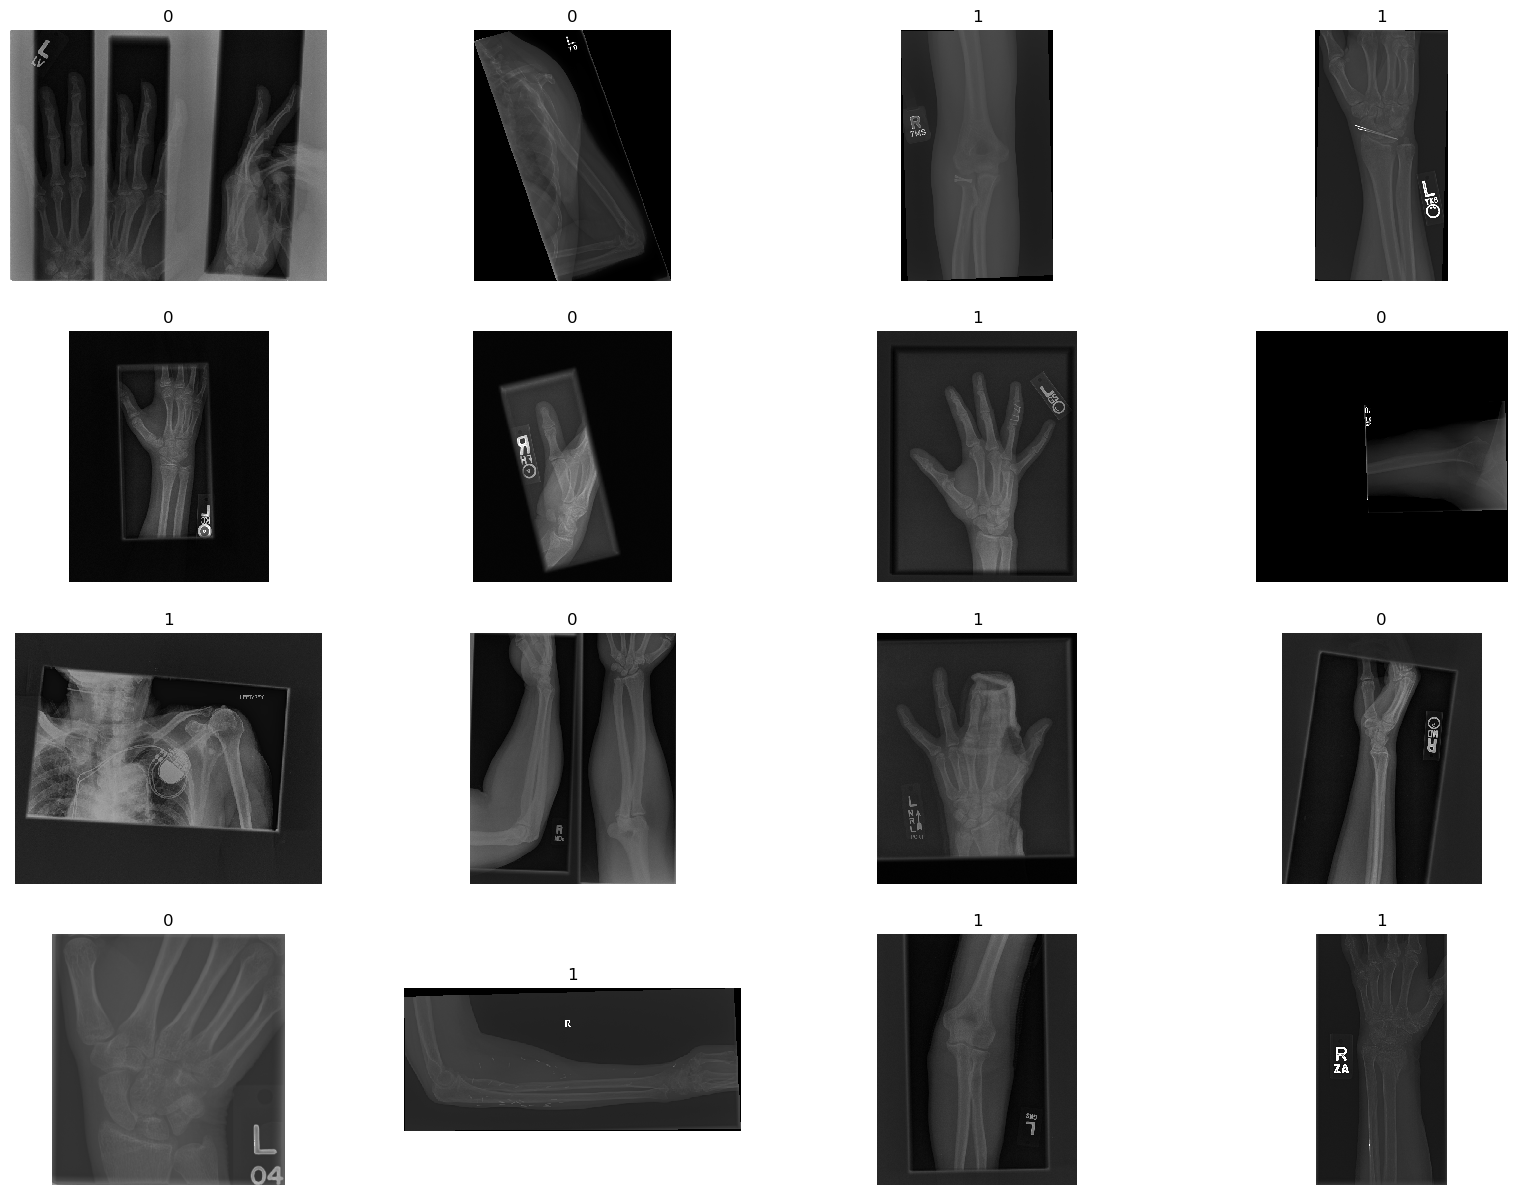

In [47]:
show_16_images(list(mura_df["path"]), list(mura_df["abnormality"]))

# Exporting mura_df as csv

In [145]:
mura_df

,path,bodypart,abnormality
0,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
1,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
2,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
3,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
4,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_SHOULDER,1
...,...,...,...
40000,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
40001,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
40002,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0
40003,/Users/felipesanmartin/Study/TFG/data/MURA-v1....,XR_FINGER,0


In [147]:
mura_df.to_csv("mura_df.csv", index = False)